In [434]:
import sys
import mailbox
import csv
import re
from collections import Counter
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [430]:
from scipy.interpolate import interp1d
import statsmodels.api as sm


/home/mufasa/anaconda2/envs/p35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
mbox_file = '/mnt/c/Users/itay/Documents/YACV-002.mbox'

In [4]:
def gen_summary(filename, limit = 10):
    mbox = mailbox.mbox(filename)
    i = 0
    for message in mbox:
        subj = message['subject']
        print(subj)
        i += 1
        if (i >= limit):
            break



In [71]:
def summary_to_csv(mbox_file, output_file, limit = 10):
    mbox = mailbox.mbox(mbox_file)
    i = 0
    with open(output_file, "w", encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file, delimiter='\t')
        for msg in mbox:
            try:
                line = get_basic_data(msg)
            except TypeError as e:
                print('TypeError in line %d: %s' % (i, str(e)))
            except ValueError as e:
                print('ValueError in line %d: %s' % (i, str(e)))
            except LookupError as e:
                print('LookupError in line %d: %s' % (i, str(e)))
                
            writer.writerow(line)        
            i += 1
            if (i >= limit):
                break



In [72]:
# %%time
summary_to_csv(mbox_file, 'test_10k.tsv', limit=10000)

TypeError in line 961: expected string or bytes-like object
TypeError in line 2792: expected string or bytes-like object
LookupError in line 3996: unknown encoding: iso-8859-8-i
TypeError in line 5322: expected string or bytes-like object
TypeError in line 5511: expected string or bytes-like object
TypeError in line 6299: expected string or bytes-like object
TypeError in line 6313: expected string or bytes-like object
TypeError in line 6780: expected string or bytes-like object
TypeError in line 7294: expected string or bytes-like object
TypeError in line 8143: expected string or bytes-like object
TypeError in line 8376: expected string or bytes-like object
LookupError in line 8430: unknown encoding: iso-8859-8-i
TypeError in line 8965: expected string or bytes-like object
TypeError in line 8973: expected string or bytes-like object
TypeError in line 9000: expected string or bytes-like object
TypeError in line 9002: expected string or bytes-like object
TypeError in line 9003: expected 

In [47]:
def get_basic_data(msg):
    subject = get_decoded_subject(msg)
    ts = parsedate_to_datetime(msg['Date']).strftime("%b %d %Y %H:%M:%S")
    atts = get_att_names_decoded(msg)
    return [subject, ts, atts]
    
    
    
    
    

In [54]:
output_file = 'test.csv'
with open(output_file, "w", encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file, delimiter='\t')
    for msg in msgs:
        line = get_basic_data(msg)
        writer.writerow(line)

In [73]:
df = pd.read_csv('test_10k.tsv', sep='\t', names=['subject', 'date', 'att_list'])


In [74]:
len(df)

10000

In [5]:
gen_summary(mbox_file)

=?UTF-8?B?W1lBQ1ZdINec15nXnNeaINeb16rXkdeg15kgLSDXnNee16nXqNeqIEp1bmlvciBRQQ==?=
[YACV] [CV] Shai Medad - Software Development positions
[YACV] Aidoc is Looking for Marketing Experts
[YACV] [job] Several open positions at White Noise
[YACV] Coneuron is hiring
[YACV] [job] Smart Junior Data QA @ Pipl
[YACV] [Job] User acquisition manager at GuruShots
[YACV] [JOB] Senior Backend Engineer at Donde
[YACV][CV] Raz Zahavi - Analyst Positions
[YACV] [CV] Shmuel Fisher - Test automation developer


In [6]:
def get_a_few(filename, limit = 10):
    mbox = mailbox.mbox(filename)
    res = []
    i = 0
    for message in mbox:
        res.append(message)
        i += 1
        if (i >= limit):
            break
    
    return res
    

In [8]:
msgs = get_a_few(mbox_file)

In [11]:
msg = msgs[1]

In [13]:
msg['Date'], msg['subject']

('Mon, 4 Dec 2017 14:36:01 +0200',
 '[YACV] [CV] Shai Medad - Software Development positions')

In [14]:
from email.utils import parsedate_to_datetime

In [16]:
dt = parsedate_to_datetime(msg['Date'])

In [18]:
dt.strftime("%b %d %Y %H:%M:%S")

'Dec 04 2017 14:36:01'

In [458]:
# getbody(msgs[1])

In [44]:
decode_header(msgs[0]['subject'])

[(b'[YACV] \xd7\x9c\xd7\x99\xd7\x9c\xd7\x9a \xd7\x9b\xd7\xaa\xd7\x91\xd7\xa0\xd7\x99 - \xd7\x9c\xd7\x9e\xd7\xa9\xd7\xa8\xd7\xaa Junior QA',
  'utf-8')]

In [46]:
for msg in msgs:
    print(get_decoded_subject(msg))

[YACV] לילך כתבני - למשרת Junior QA
[YACV] [CV] Shai Medad - Software Development positions
[YACV] Aidoc is Looking for Marketing Experts
[YACV] [job] Several open positions at White Noise
[YACV] Coneuron is hiring
[YACV] [job] Smart Junior Data QA @ Pipl
[YACV] [Job] User acquisition manager at GuruShots
[YACV] [JOB] Senior Backend Engineer at Donde
[YACV][CV] Raz Zahavi - Analyst Positions
[YACV] [CV] Shmuel Fisher - Test automation developer


In [45]:
def get_decoded_subject(msg):
    decoded = decode_header(msg['subject'])
    first_element = decoded[0]
    if (first_element[1] is not None):
        return str(first_element[0], first_element[1])
    else:
        return first_element[0]

In [23]:
def get_att_names(message): #getting plain text 'email body'
    body = None
    names = []
    if message.is_multipart():
        for part in message.walk():
            if ((not part.is_multipart()) and (part.get('Content-Disposition') is not None)):
                fileName = part.get_filename()
                names.append(fileName)
    
    return names


In [36]:
import unicode

ImportError: No module named 'unicode'

In [41]:
def get_att_names_decoded(msg):    
    att_names_decoded = []
    for att_name in get_att_names(msg):
        decoded = decode_header(att_name)
        for decoded_obj in decoded:
            encoding = decoded_obj[1]
            if (encoding is not None):
                s = str(decoded_obj[0], decoded_obj[1])
                att_names_decoded.append(s)
            else:
                att_names_decoded.append(decoded_obj[0])
    
    return att_names_decoded


In [42]:
for msg in msgs:
    print(get_att_names_decoded(msg))

['לילך כתבני - 2018.pdf']
['Shai Medad CV.pdf']
[]
[]
[]
[]
[]
[]
['Raz Zahavi - CV.pdf']
['קורות חיים - שמואל פישר.docx']


In [ ]:
s = unicode(your_object).encode('utf8')
f.write(s)

In [26]:
from email.header import decode_header

In [28]:
for msg in msgs:
    
    print(list(map(lambda x: decode_header(x), get_att_names(msg))))

[[(b'\xd7\x9c\xd7\x99\xd7\x9c\xd7\x9a \xd7\x9b\xd7\xaa\xd7\x91\xd7\xa0\xd7\x99 - 2018.pdf', 'utf-8')]]
[[('Shai Medad CV.pdf', None)]]
[]
[]
[]
[]
[]
[]
[[('Raz Zahavi - CV.pdf', None)]]
[[(b'\xd7\xa7\xd7\x95\xd7\xa8\xd7\x95\xd7\xaa \xd7\x97\xd7\x99\xd7\x99\xd7\x9d - \xd7\xa9\xd7\x9e\xd7\x95\xd7\x90\xd7\x9c \xd7\xa4\xd7\x99\xd7\xa9\xd7\xa8.docx', 'utf-8')]]


In [459]:
# print(msgs[1])

In [19]:
def getbody(message): #getting plain text 'email body'
    body = None
    if message.is_multipart():
        for part in message.walk():
            if part.is_multipart():
                for subpart in part.walk():
                    if subpart.get_content_type() == 'text/plain':
                        body = subpart.get_payload(decode=True)
            elif part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True)
    elif message.get_content_type() == 'text/plain':
        body = message.get_payload(decode=True)
    return body

We'll want:
- date
- subject
- body
- has attachment? / number of attachments
- attachment data?

In [ ]:
if __name__ == "__main__":
    if len(sys.argv) != 2:
        print 'Usage: python genarchivesum.py mbox'
        sys.exit(1)

    gen_summary(sys.argv[1])

## Analysis

In [292]:
# df = pd.read_csv('test_10k.tsv', sep='\t', names=['subject', 'date', 'att_list'])
df = pd.read_csv('test_1M.tsv', sep='\t', names=['subject', 'date', 'att_list'])

### Basic Analysis

In [296]:
len(df)

14465

In [426]:
df['datetime'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, "%b %d %Y %H:%M:%S"))

In [427]:
min(df['datetime']), max(df['datetime'])

(Timestamp('2014-01-27 10:10:46'), Timestamp('2018-03-22 14:20:22'))

In [294]:
text = "".join(df['subject'])
# wordcloud = WordCloud().generate(text)

In [295]:
len(text)

771898

### Tag Pie Chart

In [298]:
tags = re.findall(r'\[[A-Za-z0-9]+\]', text)

In [299]:
norm_tags = [x.upper() for x in tags]

In [300]:
len(norm_tags)

22690

In [301]:
tag_counts = Counter(norm_tags)

In [302]:
del tag_counts["[YACV]"]

In [303]:
top_tags = tag_counts.most_common(3)
labels, sizes = list(zip(*top_tags))
labels = list(labels)
sizes = list(sizes)

In [304]:
the_rest = {k:v for k,v in tag_counts.items() if k not in labels}

In [305]:
the_rest_sum = sum(the_rest.values())

In [306]:
the_rest_sum

600

In [307]:
labels.append('all other tags')
sizes.append(the_rest_sum)

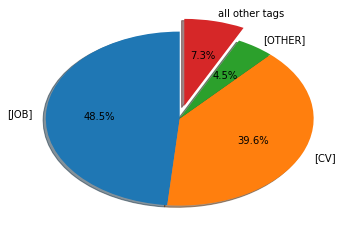

In [308]:
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, explode = [.15 if (i == len(sizes)-1) else 0 for i in range(len(sizes))])
plt.show()

### Word  Clouds

In [211]:
def get_text_of_tag(df, tag):
    return [x for x in df['subject'] if (tag in x)]

In [255]:
def norm_text_from_arr(text_arr):
    text = "".join(text_arr)
    text_st = re.sub(r'[^a-zA-Z0-9]+',' ', text)
    text_st = re.sub(r'\bYACV\b',' ', text_st)
    text_st = re.sub(r'\s+',' ', text_st)
    text_st = text_st.lower()
    
    return text_st

In [273]:
stopwords=['for', 'Re', 'and', 'is', 'or', 'a', 'in', 'to', 'of', 'at', 're', 'the']

In [250]:
def norm_counter_from_text(text):
    ctr = Counter(text.split(" "))
    
    for w in stopwords:
        del ctr[w]
        
    return ctr

In [289]:
def draw_wordcloud(ctr):
    wct = WordCloud(max_font_size=100, max_words=100, colormap="Set3")
    wordcloud = wct.generate_from_frequencies(ctr)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [309]:
cv_text_arr = get_text_of_tag(df, '[CV]')
job_text_arr = get_text_of_tag(df, '[JOB]')
len(cv_text_arr), len(job_text_arr)

(3239, 3599)

In [310]:
cv_text = norm_text_from_arr(cv_text_arr)
job_text = norm_text_from_arr(job_text_arr)

In [311]:
cv_ctr = norm_counter_from_text(cv_text)
job_ctr = norm_counter_from_text(job_text)

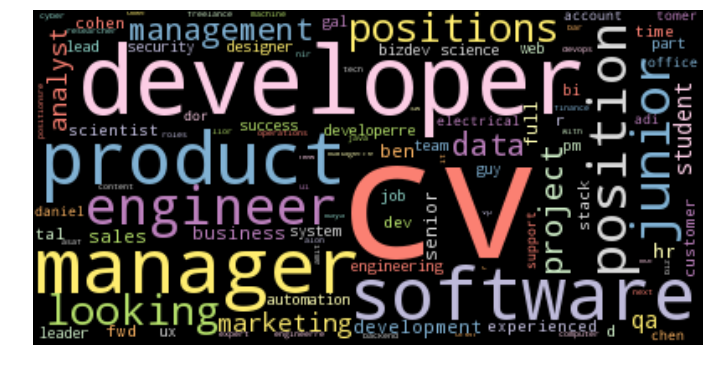

In [315]:
draw_wordcloud(cv_ctr)

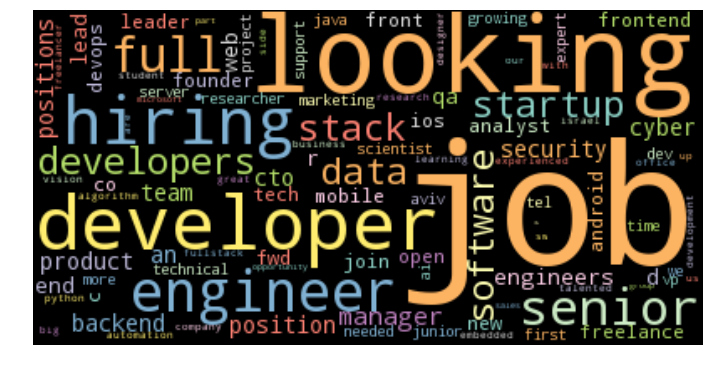

In [313]:
draw_wordcloud(job_ctr)

### Time Series


In [326]:
s =df.head()['date'][0]
s

'Feb 27 2018 05:35:57'

In [350]:
datetime.datetime.strptime(s, "%b %d %Y %H:%M:%S").strftime("%Y-%m")


'2018-02'

In [351]:
df['month'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, "%b %d %Y %H:%M:%S").strftime("%Y-%m"))


In [336]:
df['is_cv'] = df['subject'].apply(lambda x: 1 if '[CV]' in x else 0)
df['is_job'] = df['subject'].apply(lambda x: 1 if '[JOB]' in x else 0)

In [361]:
cv_pivot = pd.pivot_table(df,index=["month"], values='is_cv', aggfunc=[sum, len]).reset_index()

In [377]:
cv_pivot['pct_cv'] = cv_pivot['sum']['is_cv'] / cv_pivot['len']['is_cv']

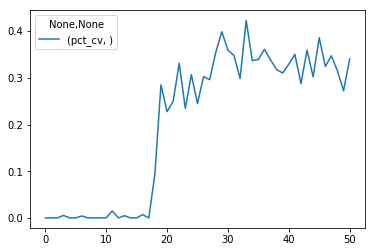

In [381]:
cv_pivot[['month', 'pct_cv']].plot()

In [383]:
job_pivot = pd.pivot_table(df,index=["month"], values='is_job', aggfunc=[sum, len]).reset_index()
job_pivot['pct_job'] = job_pivot['sum']['is_job'] / job_pivot['len']['is_job']

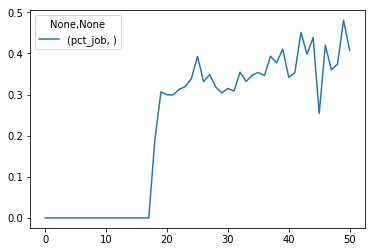

In [384]:
job_pivot[['month', 'pct_job']].plot()

In [388]:
table = pd.pivot_table(df,index=["month"], values=['is_cv', 'is_job'], aggfunc=[sum, len]).reset_index()

In [392]:
table = pd.pivot_table(df,index=["month"], values=['is_cv', 'is_job'], aggfunc=[sum, len]).reset_index()
table['pct_job'] = table['sum']['is_job'] / table['len']['is_job']
table['pct_cv'] = table['sum']['is_cv'] / table['len']['is_cv']

In [393]:
table['cv_to_job_ratio'] = table['pct_cv'] / table['pct_job']

In [397]:
data = table[18:]

In [455]:
x = range(len(data['month']))
y = data['cv_to_job_ratio']
          

In [456]:
lowess = sm.nonparametric.lowess(y, x, frac=.25)
# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = np.arange(0, len(x), 0.1)

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)

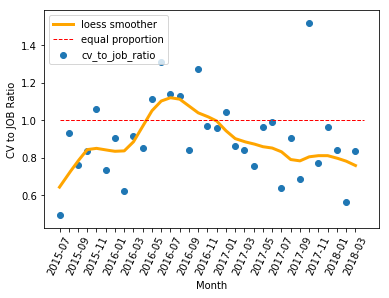

In [457]:
plt.scatter(x=x, y=y)
xt = plt.xticks(x, [x if i % 2 == 0 else '' for i,x in enumerate(list(data['month']))], rotation=65)
plt.plot(xnew, ynew, '-', color='orange', linewidth=3, label='loess smoother')
plt.plot(xnew, [1. for x in xnew], '-', color='red', linewidth=1, linestyle='dashed', label='equal proportion')
plt.xlabel('Month')
plt.ylabel('CV to JOB Ratio')
plt.legend(loc='upper left')